## Adding lengthscale for WD kernel

Take the WD kernel and calculate the squared distance matrix corresponding to it. For this squared distance matrix, you can compute the Gaussian kernel using the formula exp(-D^2/(length scale))

Try length scales of quantiles of the squared distance = 0.05, 0.1, 0.3, 0.5

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

df_known = pd.read_csv(Path)

In [3]:
def generate_design_space(known_rbs_set):
        # create all combos

        combos = [] # 20-base
        combos_6 = [] # 6-base

        # Setting
        char_sets = ['A', 'G', 'C', 'T']
        design_len = 6
        pre_design = 'TTTAAGA'
        pos_design = 'TATACAT'

        for combo in itertools.product(char_sets, repeat= design_len):
            combo = pre_design + ''.join(combo) + pos_design
            combos_6.append(''.join(combo))
            combos.append(combo)
            
        assert len(combos) == len(char_sets) ** design_len

        df_design = pd.DataFrame()
        df_design['RBS'] = [x for x in combos if x not in known_rbs_set]
        df_design['RBS6'] = df_design['RBS'].str[7:13]

        return df_design

In [4]:
df_design = generate_design_space(set(df_known['RBS']))
df_train_test = pd.concat([df_known, df_design], sort = True).reset_index()

In [5]:
df_train_test

,level_0,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,Rep7,Rep8,Rep9,Replicates,Round,STD,Unnamed: 0,Unnamed: 16,Usable,index
0,0,2.575968,reference,RBS_1by1_0,0.282440,First_Plate,NaN,NaN,NaN,TTTAAGAAGGAGATATACAT,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.313540,0.0,NaN,Yes,NaN
1,1,1.839138,bps_noncore,RBS_1by1_1,0.285821,First_Plate,NaN,NaN,NaN,CTTAAGAAGGAGATATACAT,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.268820,1.0,NaN,Yes,NaN
2,2,0.646754,bps_noncore,RBS_1by1_2,0.370243,First_Plate,NaN,NaN,NaN,GTTAAGAAGGAGATATACAT,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.188587,2.0,NaN,Yes,NaN
3,3,1.598899,bps_noncore,RBS_1by1_3,0.313749,First_Plate,NaN,NaN,NaN,ATTAAGAAGGAGATATACAT,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.220191,3.0,NaN,Yes,NaN
4,4,1.812638,bps_noncore,RBS_1by1_4,0.216994,First_Plate,NaN,NaN,NaN,TCTAAGAAGGAGATATACAT,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.300722,4.0,NaN,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4134,3868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTGTTATACAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4135,3869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTCATATACAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4136,3870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTCGTATACAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4137,3871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTCCTATACAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


init kernel


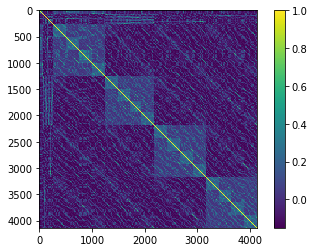

In [6]:
kernel = WD_Shift_Kernel(l=6, features=np.asarray(df_train_test['RBS']), sigma_0=1, lengthscale_rate = None)
plt.imshow(kernel.kernel_all_normalised)
plt.colorbar()

Text(0.5, 1.0, 'Histogram of upper triangle of D^2')

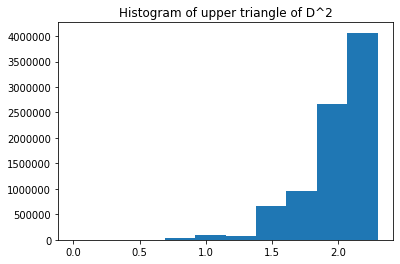

In [7]:
distance_square = kernel.distance_all**2
plt.hist(distance_square[np.triu_indices(kernel.distance_all.shape[0])])
plt.title('Histogram of upper triangle of D^2')

lengthscale:  1.400114959490268
init kernel
lengthscale:  1.6067471389477954
init kernel
lengthscale:  1.8998872829564664
init kernel
lengthscale:  2.0398674657517653
init kernel


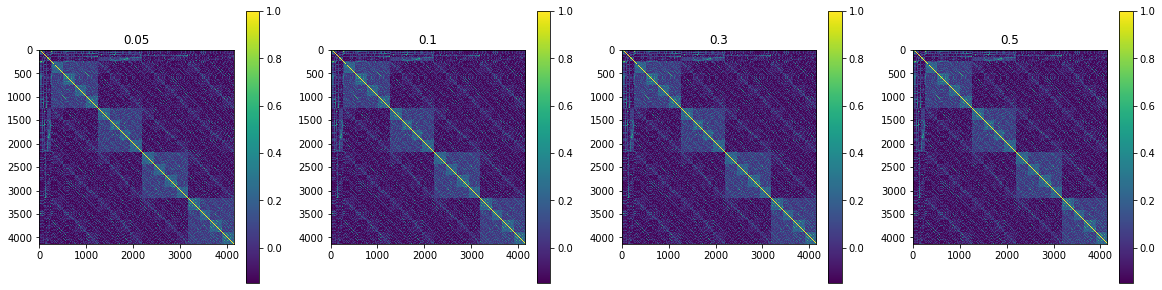

In [17]:
num_rows = 1
num_cols = 4

fig,ax = plt.subplots(num_rows, num_cols, figsize = (20,5))

for i, lengthscale_rate in enumerate([0.05,0.1,0.3,0.5]):
    WD_Shift_Kernel.INIT_FLAG = False
    kernel = WD_Shift_Kernel(l=6, features=np.asarray(df_train_test['RBS']), sigma_0=1, lengthscale_rate = lengthscale_rate)
    im = ax[i].imshow(kernel.kernel_all_normalised)
    ax[i].set_title(lengthscale_rate)
    plt.colorbar(im, ax=ax[i])